In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("cookie_cats.csv")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 2. The AB-test data
<p>The data we have is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the group with the moved gate (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first 14 days after install.</li>
<li><code>retention_1</code> - did the player come back and play <strong>1 day</strong> after installing?</li>
<li><code>retention_7</code> - did the player come back and play <strong>7 days</strong> after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. As a sanity check, let's see if there are roughly the same number of players in each AB group. </p>

In [3]:
df.groupby("version").count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489



It looks like there is roughly the same number of players in each group, nice!

Text(0, 0.5, 'userid')

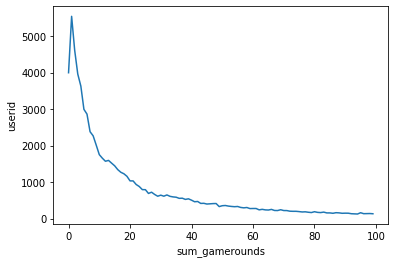

In [6]:
plot_df = df.groupby("sum_gamerounds")["userid"].count()

# Plotting the distribution of players that played 0 to 100 game rounds
ax = plot_df[:100].plot()
ax.set_xlabel("sum_gamerounds")
ax.set_ylabel("userid")

In the plot above we can see that some players install the game but then never play it (0 game rounds), some players just play a couple of game rounds in their first week, and some get really hooked!

As a first step, let's look at what 1-day retention is overall.

In [7]:
df["retention_1"].mean()

0.4452095044850259

So, a little less than half of the players come back one day after installing the game. Now that we have a benchmark, let's look at how 1-day retention differs between the two AB-groups

In [8]:
df.groupby("version")["retention_1"].mean()

version
gate_30    0.448188
gate_40    0.442283
Name: retention_1, dtype: float64

It appears that there was a slight decrease in 1-day retention when the gate was moved to level 40 (44.2%) compared to the control when it was at level 30 (44.8%). It's a small change, but even small changes in retention can have a large impact

There are a couple of ways we can get at the certainty of these retention numbers. Here we will use bootstrapping: We will repeatedly re-sample our dataset (with replacement) and calculate 1-day retention for those samples. The variation in 1-day retention will give us an indication of how uncertain the retention numbers are.

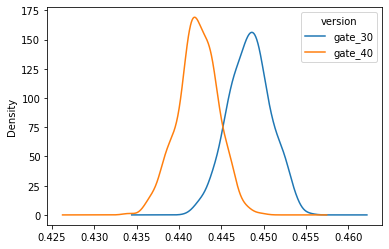

In [9]:
boot_1d = []
for i in range(500):
    boot_mean = df.sample(frac=1, replace=True).groupby("version")["retention_1"].mean()
    boot_1d.append(boot_mean)
    
boot_1d = pd.DataFrame(boot_1d)
boot_1d.plot.density()

These two distributions above represent the bootstrap uncertainty over what the underlying 1-day retention could be for the two AB-groups. Just eyeballing this plot, we can see that there seems to be some evidence of a difference, albeit small. Let's zoom in on the difference in 1-day retention

Text(0.5, 0, 'diff')

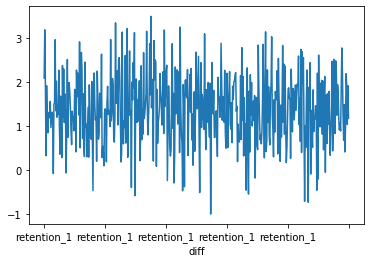

In [10]:
# Adding a column with the % difference between the two AB-groups
boot_1d['diff'] = (boot_1d["gate_30"] - boot_1d["gate_40"])/boot_1d["gate_40"]*100

ax = boot_1d["diff"].plot()
ax.set_xlabel("diff")

From this chart, we can see that the most likely % difference is around 1% - 2%, and that most of the distribution is above 0%, in favor of a gate at level 30. But what is the probability that the difference is above 0%? Let's calculate that as well.

In [11]:
# Calculating the probability that 1-day retention is greater when the gate is at level 30
prob = (boot_1d["diff"]>0).mean()

# Pretty printing the probability
print(prob)

0.96


## 7-day retention by AB-group
<p>The bootstrap analysis tells us that there is a high probability that 1-day retention is better when the gate is at level 30. However, since players have only been playing the game for one day, it is likely that most players haven't reached level 30 yet. That is, many players won't have been affected by the gate, even if it's as early as level 30. </p>
<p>But after having played for a week, more players should have reached level 40, and therefore it makes sense to also look at 7-day retention. That is: What percentage of the people that installed the game also showed up a week later to play the game again.</p>
<p>Let's start by calculating 7-day retention for the two AB-groups.</p>

In [12]:
df.groupby("version")["retention_7"].mean()

version
gate_30    0.190201
gate_40    0.182000
Name: retention_7, dtype: float64

Like with 1-day retention, we see that 7-day retention is slightly lower (18.2%) when the gate is at level 40 than when the gate is at level 30 (19.0%). This difference is also larger than for 1-day retention, presumably because more players have had time to hit the first gate. We also see that the overall 7-day retention is lower than the overall 1-day retention; fewer people play a game a week after installing than a day after installing.

But as before, let's use bootstrap analysis to figure out how certain we should be of the difference between the AB-groups.

0.998


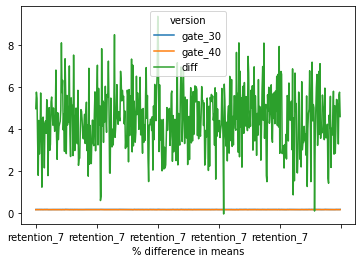

In [13]:
boot_7d = []
for i in range(500):
    boot_mean = df.sample(frac=1,replace=True).groupby("version")["retention_7"].mean()
    boot_7d.append(boot_mean)
    
# Transforming the list to a DataFrame
boot_7d = pd.DataFrame(boot_7d)

# Adding a column with the % difference between the two AB-groups
boot_7d['diff'] = (boot_7d["gate_30"]-boot_7d["gate_40"]) / boot_7d["gate_40"]*100

# Ploting the bootstrap % difference
ax = boot_7d.plot()
ax.set_xlabel("% difference in means")

# Calculating the probability that 7-day retention is greater when the gate is at level 30
prob = (boot_7d["diff"]>0).mean()

# Pretty printing the probability
print(prob)

The bootstrap result tells us that there is strong evidence that 7-day retention is higher when the gate is at level 30 than when it is at level 40. 

The conclusion is: If we want to keep retention high — both 1-day and 7-day retention — we should not move the gate from level 30 to level 40. There are, of course, other metrics we could look at, like the number of game rounds played or how much in-game purchases are made by the two AB-groups. But retention is one of the most important metrics. If we don't retain our player base, it doesn't matter how much money they spend in-game.